# Understanding the problem

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

# Understanding the Dataset

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
df = pd.read_csv("train_sample.csv")
df.head(4)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0


In [4]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [6]:
len(df)

100000

In [7]:
# check the number of unique values in each Columns

def unique_val(x):
    return len(df[x].unique())

unique_val_number = {x: unique_val(x) for x in df.columns}
unique_val_number

{'ip': 34857,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'attributed_time': 228,
 'is_attributed': 2}

In [8]:
df["attributed_time"].value_counts()

2017-11-07 03:33:02    1
2017-11-08 10:47:46    1
2017-11-09 12:49:58    1
2017-11-07 05:34:58    1
2017-11-09 15:17:13    1
                      ..
2017-11-08 03:35:22    1
2017-11-07 09:03:35    1
2017-11-07 11:22:32    1
2017-11-07 07:56:49    1
2017-11-09 07:11:19    1
Name: attributed_time, Length: 227, dtype: int64

In [9]:
df["attributed_time"].isna().sum()

99773

In [10]:
# the "attributed_time" column almost fill with missing values.lets drop the col

#df = df.drop(["attributed_time"],axis = 1)
df.head(4)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0


In [11]:
df.drop(["attributed_time"],axis = 1,inplace =True)

In [12]:
df.head(4)

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0


In [13]:
df.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

 There are certain "apps" which have quite high number of instances/rows (each row is click)

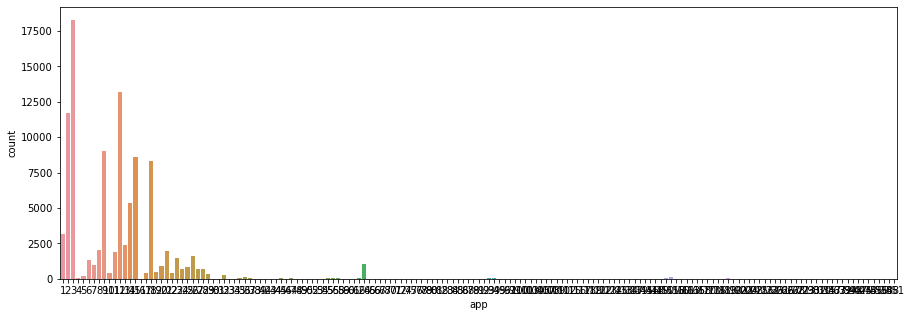

In [14]:
## distributions of "app"

plt.subplots(figsize = (15,5))
sns.countplot(x = "app",data = df)

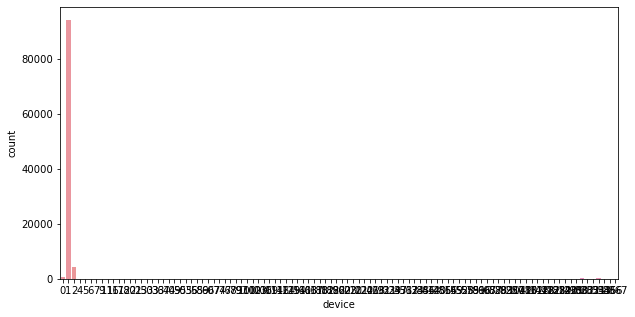

In [15]:
# distributions of "devices"

plt.subplots(figsize = (10,5))
sns.countplot(x = "device",data = df)

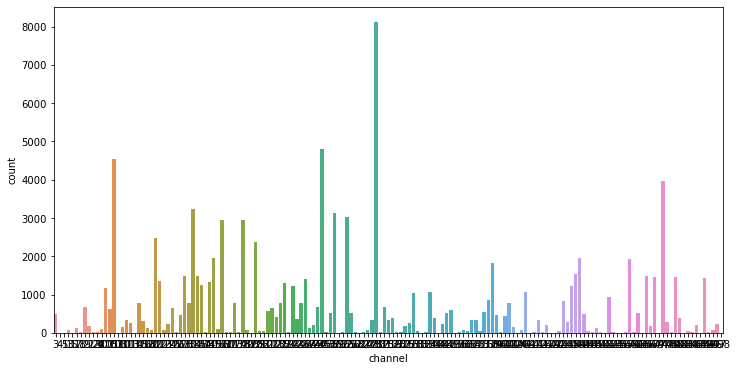

In [16]:
#Channel :various channel get clicks in a compareable quantities
plt.subplots(figsize = (12,6))
sns.countplot(x = "channel",data = df)

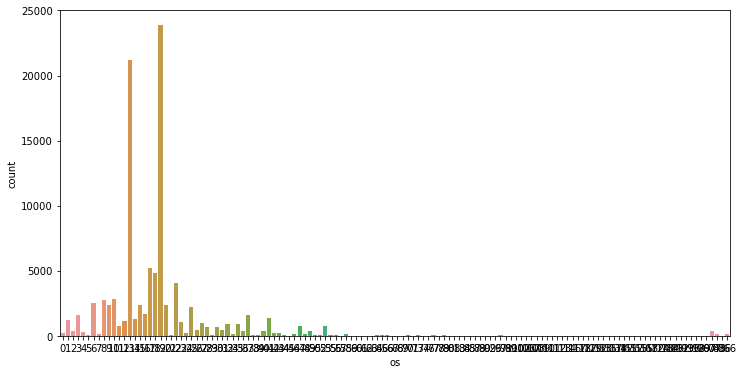

In [17]:
# os distributions

plt.subplots(figsize = (12,6))
sns.countplot(x = "os",data = df)

some common os were highly used than others

In [18]:
# Now lets look at the distributions of target variable "is_attribute"

100*(df["is_attributed"].astype('object').value_counts()/len(df.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only **about 0.2% clicks are 'Frudulent**.This is such an highly class imblance problem

# Exploring The Data - Segmented Univariate Analysis

Lets look at the target variable varies with various predictor

In [19]:
app_target = df.groupby("app").is_attributed.agg(["mean","count"])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


This is non readable.Lets get rid of the apps that are very rare(say which comprise of less than 20% clicks) and plot this.

In [20]:
frequent_apps = df.groupby("app").size().reset_index(name = "count")
frequent_apps = frequent_apps[frequent_apps["count"]>frequent_apps["count"].quantile(0.80)]
frequent_apps = frequent_apps.merge(df,on = 'app',how = 'inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


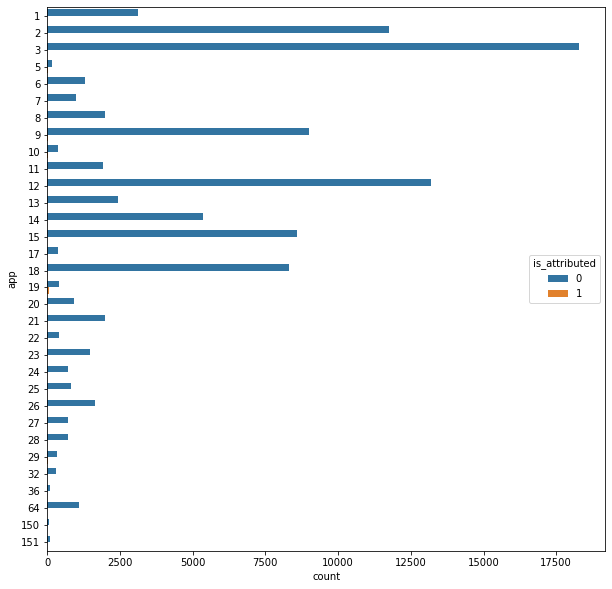

In [21]:
plt.figure(figsize = (10,10))
sns.countplot(y = "app",hue = "is_attributed",data = frequent_apps)

# Feature Engineering

Lets derive some new features from existing one.

# Datetime Based Feature

In [22]:
def timefeatures(dff):
    dff["datetime"] = pd.to_datetime(dff["click_time"])
    dff["day_of_week"] = dff["datetime"].dt.dayofweek
    dff["day_of_year"] = dff["datetime"].dt.dayofyear
    dff["month"] = dff["datetime"].dt.month
    dff["hour"] = dff["datetime"].dt.hour
    
    return dff

In [23]:
#creating new datetime variables and drop the old one

df = timefeatures(df)
df.drop(["datetime","click_time"],axis = 1,inplace = True)
df.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


In [24]:
df.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int64
day_of_year      int64
month            int64
hour             int64
dtype: object

In [25]:
# memory used by training data
print(f"Training dataset uses :{(df.memory_usage().sum())/1024**2} MB")

Training dataset uses :7.6295166015625 MB


In [26]:
#Lets convert the variables back to lower dtype again
int_vars = ["ip","app","device","os","channel","day_of_week","day_of_year","month","hour","is_attributed"]
df[int_vars] = df[int_vars].astype("uint16")

In [27]:
df.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint16
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [28]:
print(f"Training Dataset Memory Usage :{(df.memory_usage().sum())/1024**2} MB")

Training Dataset Memory Usage :1.907470703125 MB


# IP Grouping Based Feature

In [29]:
ip_count = df.groupby("ip").size().reset_index(name = "ip_count").astype('int16')
ip_count.head(4)

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1


In [44]:
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [31]:
df.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [32]:
df.isna().sum()

ip               0
app              0
device           0
os               0
channel          0
is_attributed    0
day_of_week      0
day_of_year      0
month            0
hour             0
dtype: int64

In [37]:
df_c = df.copy()
df_c.head(4)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4


In [45]:
df_1 = df.copy()
df_1 = grouped_features(df_1)
df_1.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


# Modeling

In [46]:
X = df_1.drop(["is_attributed"],axis = 1)
y = df_1["is_attributed"]

In [47]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state = 22)

# Adaboost

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#base estimator
tree = DecisionTreeClassifier(max_depth = 2)

#adaboost with base estimator
adaboost_model = AdaBoostClassifier(base_estimator = tree,
                                    n_estimators = 600,
                                    learning_rate = 1.5,
                                    algorithm = "SAMME")

In [49]:
adaboost_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [50]:
adaboost_model.score(X_test,y_test)

0.9973

In [51]:
pred = adaboost_model.predict(X_test)
y_pred_proba = adaboost_model.predict_proba(X_test)

In [52]:
from sklearn import metrics

In [54]:
# matrics: AUC 
metrics.roc_auc_score(y_test,y_pred_proba[:,1])

0.9748259473592731

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

array([[19938,    15],
       [   39,     8]], dtype=int64)

# Adaboost Hyperparameter Tuning

In [58]:
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid = {"base_estimator__max_depth":[2,4],
              "n_estimators":[300,400,500]}

#base estimator

tree = DecisionTreeClassifier()

ABC = AdaBoostClassifier(base_estimator = tree,
                         learning_rate = 0.6,
                         algorithm = "SAMME")

#Grid Search

grid_ABC = GridSearchCV(ABC,
                        cv = 5,
                        param_grid = param_grid,
                        scoring = "roc_auc",
                        return_train_score = True,
                        verbose = 1)

In [61]:
#Fit model
grid_ABC.fit(X_train,y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 24.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [62]:
#cv result
cv_result = pd.DataFrame(grid_ABC.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,22.035962,0.847592,0.406802,0.035157,2,300,"{'base_estimator__max_depth': 2, 'n_estimators...",0.959219,0.947033,0.977594,...,0.954517,0.015578,2,0.995839,0.996238,0.996881,0.997068,0.995680,0.996341,0.000551
1,28.187385,0.782813,0.515663,0.050378,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.960257,0.950713,0.976659,...,0.954954,0.015340,1,0.996908,0.996742,0.997362,0.997365,0.996712,0.997018,0.000290
2,43.152152,6.248410,0.736086,0.094257,2,500,"{'base_estimator__max_depth': 2, 'n_estimators...",0.961264,0.949587,0.977310,...,0.954382,0.016695,3,0.997334,0.997019,0.997611,0.997740,0.996904,0.997321,0.000324
3,48.562009,1.400874,0.542930,0.047875,4,300,"{'base_estimator__max_depth': 4, 'n_estimators...",0.947394,0.961385,0.970508,...,0.947944,0.018054,4,0.999867,0.999935,0.999979,0.999992,0.999906,0.999936,0.000046
4,57.341545,6.594454,0.700243,0.125098,4,400,"{'base_estimator__max_depth': 4, 'n_estimators...",0.948192,0.951987,0.976179,...,0.945690,0.020094,6,0.999972,0.999992,1.000000,1.000000,0.999958,0.999984,0.000017
5,71.288511,7.241389,0.832000,0.124482,4,500,"{'base_estimator__max_depth': 4, 'n_estimators...",0.944558,0.963365,0.973451,...,0.946314,0.021912,5,0.999999,0.999999,1.000000,1.000000,0.999996,0.999999,0.000001


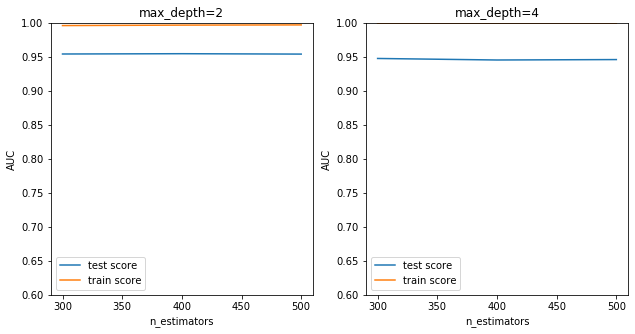

In [67]:
#plotting AUC score

plt.figure(figsize = (16,5))

for n,depth in enumerate (param_grid["base_estimator__max_depth"]):
    
    plt.subplot(1,3,n+1)
    depth_df = cv_result[cv_result['param_base_estimator__max_depth']==depth]
    
    plt.plot(depth_df["param_n_estimators"],depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"],depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='best')
    

The results above show that:

* The ensemble with max_depth=4 is clearly overfitting (training auc is almost 1, while the test score is much lower)
* At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score

In [69]:
#best_param
grid_ABC.best_params_

{'base_estimator__max_depth': 2, 'n_estimators': 400}

In [70]:
tree = DecisionTreeClassifier(max_depth = 2)

ABC = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 400,
                         learning_rate = 0.6,
                         algorithm = "SAMME")

In [71]:
ABC.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [72]:
#prediction on test data

pred_prob = ABC.predict_proba(X_test)

In [73]:
# roc_auc score

metrics.roc_auc_score(y_test,pred_prob[:,1])

0.9697683172476597

In [75]:
# confusion matrix

y_pred = ABC.predict(X_test)

confusion_matrix(y_test,y_pred)

array([[19951,     2],
       [   43,     4]], dtype=int64)

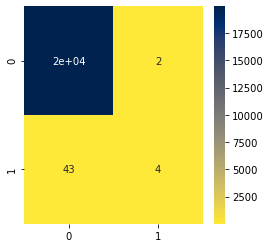

In [79]:
plt.figure(figsize = (4,4))
sns.heatmap(confusion_matrix(y_test,y_pred),
            annot =True,
            cmap = "cividis_r")

In [80]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19953
           1       0.67      0.09      0.15        47

    accuracy                           1.00     20000
   macro avg       0.83      0.54      0.57     20000
weighted avg       1.00      1.00      1.00     20000

